# **Introduction**

It's been some weeks that the competition has started. The tiling method proposed by iafoss seems giving pretty good results on public LB. 
Majority of kernels use this method to fine-tune a CNN (resnet and its variants are often used) and predict isup grade with classification or regression.

In this kernel I've tackled a different way of classifying biopsy tissues.
Indeed CNNs assume that inputs are independant of each other while RNNs assume that there is an interaction between the input sequences. The CNN could be used to extract tile features and the RNN could consider them as a sequence. The aim would be to extract the long-term dependencies of the features sequence to improve the classification accuracy. 

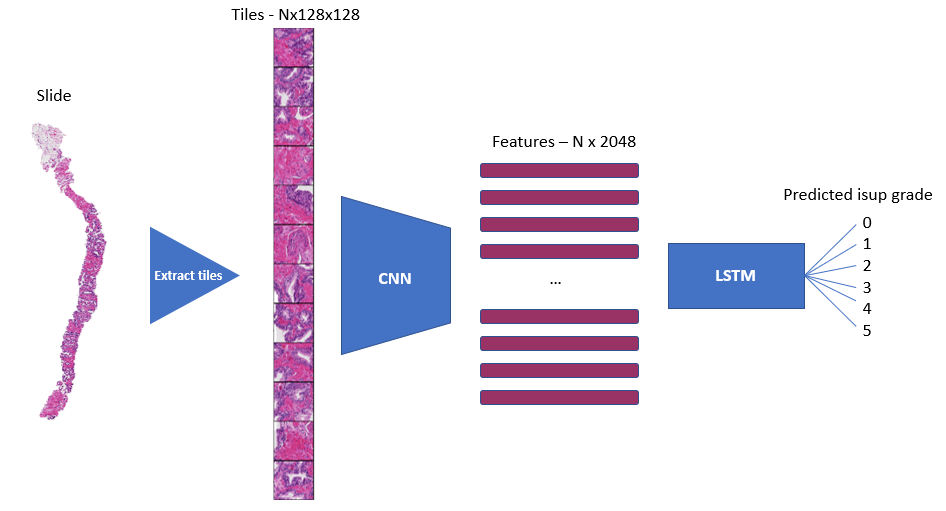

1. This is a starter kernel. Unfortunately I don't have my own hardware so I cannot do all the tests that I want because of GPU quota. I hope this kernel will provide ideas for further improvements !
2. I've "frozen" the backbone but one could train some epochs with that configuration and pursue training with the entire model 
3. One could also train the LSTM in pararell of the CNN and fuse features from both models, use some kind of attention layer to keep relevant features and perform classication.


I've used a similar training framework that https://www.kaggle.com/yasufuminakama/panda-se-resnext50-classification-baseline + iafoss tiling method https://www.kaggle.com/iafoss/panda-concat-tile-pooling-starter-0-79-lb 

# Libraries

In [ ]:
import os
import gc
import random
import sys
import time
from contextlib import contextmanager
from pathlib import Path
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import skimage.io
import cv2
import PIL
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip, Resize, \
RandomRotate90, OneOf, RandomContrast, RandomGamma, RandomBrightness, ShiftScaleRotate
import torch
from skimage.transform import AffineTransform, warp
import warnings
warnings.filterwarnings("ignore")
import torchvision
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score
import seaborn as sn
from functools import partial

# Install pre-trained models
sys.path.insert(0, '../input/pytorch-pretrained-models/semi-supervised-ImageNet1K-models-master/semi-supervised-ImageNet1K-models-master/')
from hubconf import *

#Define paths
BASE_PATH = '/kaggle/input'
TRAIN_IMG_DIR = f'{BASE_PATH}/panda-128x128x20/kaggle/train_images/'
train = pd.read_csv(f'{BASE_PATH}/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

# Global variables
MODEL_NAME = 'resnext50_32x4d_ssl' 

LOSS = 'CE' 

# Config

In [ ]:
class CFG:
    debug=False
    lr=1e-3
    batch_size=16
    epochs=5
    onecyclepolicy=False
    seed=35
    target_col='isup_grade'
    n_fold=4
    
class CFG_MODEL:
    n_out = 6 # number of classes
    lstm_layer = 2 # number of LSTM layers
    lstm_hidden_sz = 512 # Number of features in hidden state

In [ ]:
files = sorted(set([p[:32] for p in os.listdir(TRAIN_IMG_DIR)]))
train = train.loc[files]
train = train.reset_index()

# Utils

In [ ]:
def seed_everything(seed=99):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

    
def init_logger(log_file='train.log'):
    from logging import getLogger, DEBUG, FileHandler,  Formatter,  StreamHandler
    
    log_format = '%(asctime)s %(levelname)s %(message)s'
    
    stream_handler = StreamHandler()
    stream_handler.setLevel(DEBUG)
    stream_handler.setFormatter(Formatter(log_format))
    
    file_handler = FileHandler(log_file)
    file_handler.setFormatter(Formatter(log_format))
    
    logger = getLogger('PANDA')
    logger.setLevel(DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

LOG_FILE = 'train.log'
LOGGER = init_logger(LOG_FILE)

# Dataset

In [ ]:
class PandaDatasetInt:
    def __init__(self, df, N, sz, transform=None):
        self.image_ids=df.image_id.values
        self.isup_grade = df.isup_grade.values
        self.data_provider = df.data_provider.values
        self.transform=transform
        self.df=df
        self.tile_sz = sz
        self.tile_nb = N
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        fn_base = f'{TRAIN_IMG_DIR}{self.image_ids[index]}'
        img = PIL.Image.open(f"{fn_base}.png").convert('RGB')
        img = np.array(img)
        img = img.reshape(img.shape[0] // self.tile_sz, self.tile_sz, img.shape[1] // self.tile_sz, self.tile_sz, 3)
        img = img.transpose(0, 2, 1, 3, 4).reshape(-1, self.tile_sz, self.tile_sz, 3)  # Nxszxszx3
        img = img.astype(np.single)
        
        if self.transform:
            for i in range(self.tile_nb):
                aug = self.transform(image=img[i])
                img[i] = aug['image'].permute(1,2,0)
                
        label = self.isup_grade[index]
        provider = self.data_provider[index]
        return  torch.tensor(img.transpose(0, 3, 1, 2)), torch.tensor(label), provider

# Visualize

In [ ]:
# Display batch
tfm = Compose([
        ToTensorV2(),
    ])


dataset = PandaDatasetInt(train, N=20, sz=128, transform=tfm)
loader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=False)

images, label, provider = next(iter(loader))
for i in range(8):
    grid = torchvision.utils.make_grid(images[i].int(), nrow=20)
    plt.figure(figsize=(30,30))
    plt.imshow(grid.permute(1,2,0))
    plt.title(f'isup grade = {label[i].item()} | provider : {provider[i]}')

# Define model

In [ ]:
def _resnext(block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)

    return model

class Model(nn.Module):
    def __init__(self, n = 6, bs = 16, nb_layer = 1, hidden = 512, device = 'cuda'):
        super().__init__()
        self.out_dim = n
        self.hidden_sz = hidden
        self.layer_dim = nb_layer
        self.device = device
        
        # ResNext
        m = _resnext(Bottleneck, [3, 4, 6, 3], False, progress=False, groups=32, width_per_group=4)
        m.load_state_dict(torch.load('../input/pytorch-pretrained-models/semi_supervised_resnext50_32x4-ddb3e555.pth'))
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        nc = list(m.children())[-1].in_features  # 2048
        
        # LSTM
        self.lstm = nn.LSTM(nc, self.hidden_sz, self.layer_dim, dropout=0.5, batch_first=True, bidirectional=False)
        
        # FC              
        self.fc = nn.Linear(self.hidden_sz, self.out_dim)

    def forward(self, x):
        # CNN
        n = x.shape[1]
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4]) # => x: bs*N x 3 x 128 x 128
        x = self.backbone(x) # => x: bs*N x C x 1 x 1
        x = x.view(-1, n, x.shape[1], x.shape[2], x.shape[3]) # => x: bs x N x C x 1 x 1
        x = x.view(x.shape[0], x.shape[1], -1) # => x: bs x N x C
        # Shuffle the tile features
        row_idxs = list(range(x.shape[1]))
        random.shuffle(row_idxs)
        x = x[:, torch.tensor(row_idxs)]
        
        # LSTM
        # Set initial hidden states
        h0 = torch.zeros(self.layer_dim, x.shape[0], self.hidden_sz).to(self.device)
        c0 = torch.zeros(self.layer_dim, x.shape[0], self.hidden_sz).to(self.device)
        out,  h  = self.lstm(x, (h0, c0)) # => x: bs x hidden
        
        # FC
        x = self.fc(out[:, -1, :]) # => x: bs x 6
        return x

In [ ]:
if CFG.debug:
    folds = train.sample(n=50, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds = train.copy()

train_labels = folds[CFG.target_col].values
kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
    folds.loc[val_index, 'fold'] = int(fold)
folds['fold'] = folds['fold'].astype(int)
folds.to_csv('folds.csv', index=None)
folds.head()

In [ ]:
def freeze(m):
    for p in m.parameters():
        p.requires_grad = False

def unfreeze(m):
    for p in m.parameters():
        p.requires_grad = True

In [ ]:
def train_fn(fold):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"### fold: {fold} ###")
    
    lossTrain = []
    stepTrain = []
    lossVal = []
    stepVal = []
    
    step = 0
        
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    transformTrain = Compose([
        OneOf([RandomBrightness(limit=0.15), RandomContrast(limit=0.3), RandomGamma()], p=0.25),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.3),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

    transformValid = Compose([
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
                        
    train_dataset = PandaDatasetInt(folds.loc[trn_idx].reset_index(drop=True), N=20, sz=128, transform=transformTrain)
    valid_dataset = PandaDatasetInt(folds.loc[val_idx].reset_index(drop=True), N=20, sz=128, transform=transformValid)
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, num_workers=4)
    
    model = Model(n=CFG_MODEL.n_out, bs=CFG.batch_size, nb_layer=CFG_MODEL.lstm_layer, hidden=CFG_MODEL.lstm_hidden_sz, device=device)
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    if CFG.onecyclepolicy == True:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, div_factor=100, pct_start=0.0, steps_per_epoch=len(train_loader), epochs=CFG.epochs)
    else:
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, eps=1e-6)
    
    if LOSS == 'CE':
        criterion = nn.CrossEntropyLoss()
    elif LOSS == 'LabelSmoothingCE':
        criterion = label_smoothing_criterion()
        
    best_score = -100
    best_loss = np.inf
    
    # Train only the RNN and the FC
    freeze(model.backbone)
    
    for epoch in range(CFG.epochs):
        start_time = time.time()
        
        # Unfreeze backbone
        #if epoch == 5:
        #    unfreeze(model.backbone)
            
        # --------- Training loop ----------
        model.train()
        avg_loss = 0.

        optimizer.zero_grad()
        tk0 = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, (images, labels, _) in tk0:

            images = images.to(device)
            labels = labels.to(device)
            
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            lossTrain.append(loss.item())
            stepTrain.append(step)
            
            if CFG.onecyclepolicy == True:
                scheduler.step()

            avg_loss += loss.item() / len(train_loader)
            step += 1
            
        # ---------- Validation loop --------
        model.eval()
        avg_val_loss = 0.
        preds = []
        valid_labels = []
        tk1 = tqdm(enumerate(valid_loader), total=len(valid_loader))

        for i, (images, labels, _) in tk1:
            
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                y_preds = model(images)
            
            preds.append(y_preds.to('cpu').numpy().argmax(1))
            valid_labels.append(labels.to('cpu').numpy())

            loss = criterion(y_preds, labels)
            avg_val_loss += loss.item() / len(valid_loader)
            
        lossVal.append(avg_val_loss)
        stepVal.append(step)
            
        if CFG.onecyclepolicy == False:
            scheduler.step(avg_val_loss)
            
        preds = np.concatenate(preds)
        valid_labels = np.concatenate(valid_labels)
        
        LOGGER.debug(f'Counter preds: {Counter(preds)}')
        score = cohen_kappa_score(valid_labels, preds, weights='quadratic')
        
        if epoch == (CFG.epochs - 1):
            print(confusion_matrix(valid_labels, preds))

        elapsed = time.time() - start_time
        
        LOGGER.debug(f'  Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.debug(f'  Epoch {epoch+1} - QWK: {score}')
        
        if score>best_score:
            best_score = score
            LOGGER.debug(f'  Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save(model.state_dict(), f'fold{fold}_se_resnext50.pth')
            
    # Plot losses 
    plt.figure(figsize=(26,6))
    plt.subplot(1, 2, 1)
    plt.plot(stepTrain, lossTrain, label="training loss")
    plt.plot(stepVal, lossVal, label = "validation loss")
    plt.title('Loss')
    plt.xlabel('step')
    plt.legend(loc='center left')
    plt.tight_layout()
    plt.show()

In [ ]:
train_fn(0)